In [1]:
%matplotlib inline
import composeml as cp
import featuretools as ft
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
transactions = ft.demo.load_mock_customer(
    return_single_table=True,
    random_seed=0,
)

transactions[transactions.columns[:7]].head()

,transaction_id,session_id,transaction_time,product_id,amount,customer_id,device
0,298,1,2014-01-01 00:00:00,5,127.64,2,desktop
1,10,1,2014-01-01 00:09:45,5,57.39,2,desktop
2,495,1,2014-01-01 00:14:05,5,69.45,2,desktop
3,460,10,2014-01-01 02:33:50,5,123.19,2,tablet
4,302,10,2014-01-01 02:37:05,5,64.47,2,tablet


In [3]:
def total_spent(df):
    total = df["amount"].sum()
    return total

In [4]:
label_maker = cp.LabelMaker(
    target_entity='customer_id',
    time_index='transaction_time',
    labeling_function=total_spent,
    window_size='1h',
)

In [5]:
labels = label_maker.search(
    transactions.sort_values('transaction_time'),
    num_examples_per_instance=-1,
    gap=1,
)

labels.head()

Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████| customer_id: 5/5 


,customer_id,time,total_spent
id,,,
0,1,2014-01-01 00:44:25,2880.53
1,1,2014-01-01 00:45:30,2859.18
2,1,2014-01-01 00:46:35,2751.07
3,1,2014-01-01 00:47:40,2638.54
4,1,2014-01-01 00:48:45,2632.25


In [6]:
labels = labels.threshold(1200)

labels.head()

,customer_id,time,total_spent
id,,,
0,1,2014-01-01 00:44:25,True
1,1,2014-01-01 00:45:30,True
2,1,2014-01-01 00:46:35,True
3,1,2014-01-01 00:47:40,True
4,1,2014-01-01 00:48:45,True


In [7]:
labels = labels.apply_lead('1h')

labels.head()

,customer_id,time,total_spent
id,,,
0,1,2013-12-31 23:44:25,True
1,1,2013-12-31 23:45:30,True
2,1,2013-12-31 23:46:35,True
3,1,2013-12-31 23:47:40,True
4,1,2013-12-31 23:48:45,True


In [8]:
labels.describe()

Label Distribution
------------------
False     248
True      252
Total:    500


Settings
--------
gap                                    1
label_type                      discrete
labeling_function            total_spent
minimum_data                        None
num_examples_per_instance             -1
target_entity                customer_id
window_size                       <Hour>


Transforms
----------
1. threshold
  - value:    1200

2. apply_lead
  - value:    1h



In [9]:
es = ft.EntitySet('transactions')

es.entity_from_dataframe(
    'transactions',
    transactions,
    index='transaction_id',
    time_index='transaction_time',
)

es.normalize_entity(
    base_entity_id='transactions',
    new_entity_id='sessions',
    index='session_id',
    make_time_index='session_start',
    additional_variables=[
        'device',
        'customer_id',
        'zip_code',
        'session_start',
        'join_date',
        'date_of_birth',
    ],
)

es.normalize_entity(
    base_entity_id='sessions',
    new_entity_id='customers',
    index='customer_id',
    make_time_index='join_date',
    additional_variables=[
        'zip_code',
        'join_date',
        'date_of_birth',
    ],
)

es.normalize_entity(
    base_entity_id='transactions',
    new_entity_id='products',
    index='product_id',
    additional_variables=['brand'],
    make_time_index=False,
)

es.add_last_time_indexes()

Entityset: transactions
  Entities:
    transactions [Rows: 500, Columns: 5]
    sessions [Rows: 35, Columns: 4]
    customers [Rows: 5, Columns: 4]
    products [Rows: 5, Columns: 2]
  Relationships:
    transactions.session_id -> sessions.session_id
    sessions.customer_id -> customers.customer_id
    transactions.product_id -> products.product_id



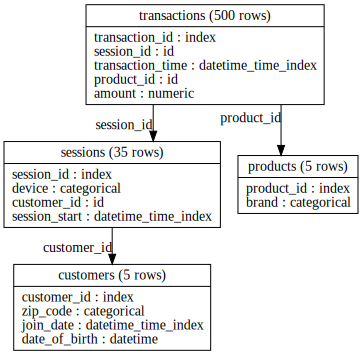

In [10]:
print(es, end='\n\n')

es.plot()

In [11]:
feature_matrix, features_defs = ft.dfs(
    entityset=es,
    target_entity='customers',
    cutoff_time=labels,
    cutoff_time_in_index=True,
    verbose=True,
)

Built 77 features
Elapsed: 00:51 | Progress: 100%|██████████


In [12]:
features_defs[:20]

[<Feature: zip_code>,
 <Feature: COUNT(sessions)>,
 <Feature: NUM_UNIQUE(sessions.device)>,
 <Feature: MODE(sessions.device)>,
 <Feature: SUM(transactions.amount)>,
 <Feature: STD(transactions.amount)>,
 <Feature: MAX(transactions.amount)>,
 <Feature: SKEW(transactions.amount)>,
 <Feature: MIN(transactions.amount)>,
 <Feature: MEAN(transactions.amount)>,
 <Feature: COUNT(transactions)>,
 <Feature: NUM_UNIQUE(transactions.product_id)>,
 <Feature: MODE(transactions.product_id)>,
 <Feature: DAY(date_of_birth)>,
 <Feature: DAY(join_date)>,
 <Feature: YEAR(date_of_birth)>,
 <Feature: YEAR(join_date)>,
 <Feature: MONTH(date_of_birth)>,
 <Feature: MONTH(join_date)>,
 <Feature: WEEKDAY(date_of_birth)>]

In [13]:
y = feature_matrix.pop('total_spent')
x = feature_matrix.fillna(0)
x, features_enc = ft.encode_features(x, features_defs)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    train_size=.8,
    test_size=.2,
    random_state=0,
)

In [15]:
clf = RandomForestClassifier(n_estimators=10, random_state=0)

clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [16]:
y_hat = clf.predict(x_test)

print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

       False       0.79      0.90      0.84        49
        True       0.89      0.76      0.82        51

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



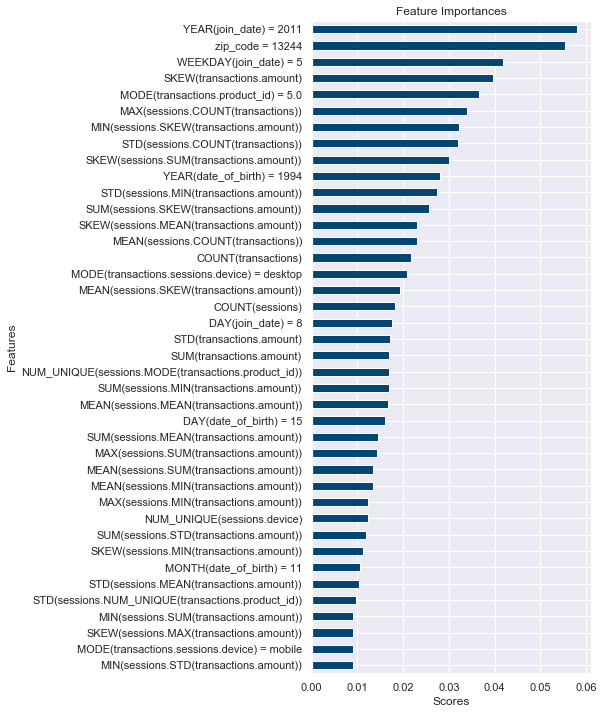

In [17]:
feature_importances = zip(x_train.columns, clf.feature_importances_)
feature_importances = pd.Series(dict(feature_importances))
feature_importances = feature_importances.rename_axis('Features')
feature_importances = feature_importances.sort_values()

top_features = feature_importances.tail(40)
plot = top_features.plot(kind='barh', figsize=(5, 12), color='#054571')
plot.set_title('Feature Importances')
plot.set_xlabel('Scores');